In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable


torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib inline

## Data-single pendulum

In [405]:
#Physical Parameters
m = 1.
L = 1.
g = 10.
T = 10*(2*np.pi*np.sqrt(L/g)) # integrate till T
Nsteps = 50000 
dt = T/Nsteps

pmax = 4
thetamax = np.pi/2.1#np.pi/6.

# 4th order yoshida
def yoshida4(thetai, vi, dt):
    c1 = 0.6756035959798289
    c2 = -0.17560359597982877
    c3 = c2
    c4 = c1
    d1 = 2*c1
    d3 = d1
    d2 = 2*(c3 - c1)
    
    thetai1 = thetai + c1 * vi * dt
    vi1 = vi + d1 * (-g/L) * np.sin(thetai1)*dt
    thetai2 = thetai1 + c2*vi1 * dt
    vi2 = vi1 + d2 * (-g/L) * np.sin(thetai2)*dt
    thetai3 = thetai2 + c3 * vi2 * dt
    vi3 = vi2 + d3 * (-g/L) * np.sin(thetai3)*dt  
    
    thetaf = thetai3 + c4 * vi3 *dt
    vf = vi3
    
    return thetaf, vf


# N initial points integrate till T
# mode = 0 : same energy
# mode = 1 : different energy
def single_pendulum_data(T, dt, N = 10, mode = 0):
    
    def random_uniform_phase_space(N):
        thetais = np.random.uniform(-thetamax, thetamax, N)
        ps = np.random.uniform(-pmax,pmax,N)
        return thetais, ps
    
    def random_same_energy(N):
        E0 = -0.0008
        vimax = np.sqrt(2*(m*g*L+E0)/(L**2*m))
        vis = np.random.uniform(-vimax, vimax, N)
        thetais = np.arccos((1/2.*m*(L*vis)**2-E0)/(m*g*L)) * (-1)**((np.random.random(N) < 0.5).astype('int'))
        #vis = np.random.uniform(1, vimax, N)
        #thetais = np.arccos((1/2.*m*(L*vis)**2-E0)/(m*g*L)) 
        return thetais, vis

    if(mode == 0):
        thetais, pis = random_same_energy(N)
    else:
        thetais, pis = random_uniform_phase_space(N)
    
    steps = int(T/dt)
    
    thetas = thetais.copy()
    ps = pis.copy()
    
    for i in range(steps):
        thetas, ps = yoshida4(thetas, ps, dt)
    
    #print('Integrated '+str(steps)+' time steps')

    return thetais, pis, thetas, ps

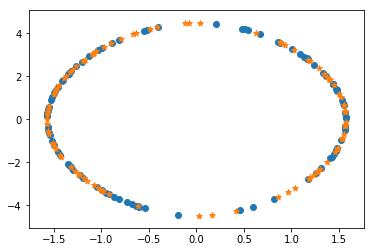

In [409]:
# produce one epoch of training data..
thetais, pis, thetafs, pfs = single_pendulum_data(0.1, dt, N = 100, mode = 0)

plt.scatter(thetais, pis)
plt.scatter(thetafs, pfs, marker = '*')

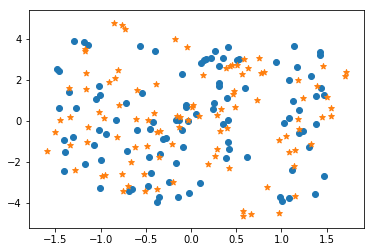

In [410]:
# produce one epoch of training data..
thetais, pis, thetafs, pfs = single_pendulum_data(0.1, dt, N = 100, mode = 1)

plt.scatter(thetais, pis)
plt.scatter(thetafs, pfs, marker = '*')

## Multiplication Net

In [411]:
# just use alpha = 1(exp) and alpha = -1(ln)
class soft_exponential(torch.nn.Module):

    def __init__(self, alpha = 0):
        super(soft_exponential, self).__init__()
        
        #alpha = np.random.uniform(low = -1., high = 1.)
        alpha = torch.Tensor([alpha])
                
        self.alpha = alpha#nn.Parameter(alpha)
    
    def forward(self, x):
        if(self.alpha<0):
            return -torch.log(1-self.alpha*(x+self.alpha))/self.alpha
        elif(self.alpha==0):
            return x
        else:
            return (torch.exp(self.alpha*x) - 1)/self.alpha + self.alpha


In [383]:
class MultiplicationNet(torch.nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(MultiplicationNet, self).__init__()
        
        self.log = soft_exponential(-1)
        
        self.input = nn.Linear(D_in, H)
        
        self.input2 = nn.Linear(D_in, H)
        
        self.exp = soft_exponential(1)
        
        self.h1 = nn.Linear(H,D_in)
        
        self.out = nn.Linear((D_in + H), D_out)
        

    def forward(self, X):
        X1 = self.input(X)
        
        ###### multiplication block #####
        X = self.log(torch.FloatTensor.abs(X))

        X = self.input2(X)
        
        X = self.exp(X)
        ###### multiplication block #####
        X = torch.sin(self.h1(X))

        X = torch.cat((X, X1), 1)

        X = self.out(X)
        
        return X

In [413]:
#Physical Parameters
m = 1.
L = 1.
g = 10.
T = 0.1
Nsteps = 50
dt = T/Nsteps

pmax = 1.0
thetamax = np.pi/6.


In [414]:
num_epochs = 10000
n_train = 300
batch_size = 30
learning_rate = 1e-4

In [415]:
model = MultiplicationNet(2, 4, 2)
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

input.weight tensor([[ 0.1570,  0.2857],
        [ 0.2719, -0.6855],
        [ 0.5761,  0.6771],
        [-0.1943,  0.3445]])
input.bias tensor([-0.5642,  0.5939, -0.4721,  0.6623])
h1.weight tensor([[ 0.1373,  0.0823,  0.2612, -0.4480],
        [ 0.4473, -0.4686, -0.0772,  0.4216],
        [ 0.1505,  0.2889,  0.1082, -0.2635],
        [-0.4550, -0.0208, -0.2275, -0.0032]])
h1.bias tensor([-0.3706, -0.2369,  0.3797, -0.3966])
out.weight tensor([[-0.3323,  0.4929,  0.3211,  0.1545],
        [-0.2517, -0.1421,  0.1568, -0.0533]])
out.bias tensor([ 0.0074, -0.3717])


In [416]:
for epoch in range(num_epochs):
    # Data for this epoch
    thetais, pis, thetafs, pfs = single_pendulum_data(0.2, dt, N = n_train, mode = 1)
    
    #d_p_theta_d_t = m*g/L *np.sin(thetais)
    
    #X = torch.Tensor(np.vstack((thetais, pis, d_p_theta_d_t)).T)
    X = torch.Tensor(np.vstack((thetais, pis)).T)
    y = torch.Tensor(np.vstack((thetafs, pfs)).T)
    
    ## TRAIN
    for i in range(int(len(X)/batch_size)):
        Xi = X[i*batch_size:(i+1)*batch_size]
        yi = y[i*batch_size:(i+1)*batch_size]
        # forward
        output = model(Xi)
        loss = criterion(output, yi)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if( (epoch+1) % int(num_epochs/10) ==0):
        print('epoch [{}/{}], loss:{:.12f}'.format(epoch + 1, num_epochs, loss.data))
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name, param.data, param.data.grad)

epoch [1000/10000], loss:0.000536303899
input.weight tensor([[ 0.6137,  0.3352],
        [ 0.6317, -0.6856],
        [ 1.1547,  0.2496],
        [-0.7057,  0.6179]]) None
input.bias tensor([-0.2937,  0.3981, -0.1424,  0.3247]) None
h1.weight tensor([[ 0.2926,  0.5125,  0.4736, -0.9082],
        [ 0.5266, -0.4565,  0.0270,  0.3517],
        [ 0.4932,  0.4992,  0.5931, -0.5217],
        [-0.2104,  0.4303,  0.1053, -0.4576]]) None
h1.bias tensor([-0.3574, -0.2993,  0.4584, -0.3924]) None
out.weight tensor([[-0.1047,  0.4874,  0.6889, -0.0267],
        [-0.6598,  0.1073, -0.3883, -0.4248]]) None
out.bias tensor([-0.0052, -0.3698]) None
epoch [2000/10000], loss:0.000067577172
input.weight tensor([[ 0.5718,  0.1942],
        [ 0.5030, -0.5312],
        [ 1.2066,  0.1068],
        [-0.5194,  0.4811]]) None
input.bias tensor([-0.2160,  0.3757, -0.0324,  0.3234]) None
h1.weight tensor([[ 0.2530,  0.5407,  0.5098, -0.9416],
        [ 0.5743, -0.5433,  0.0696,  0.3913],
        [ 0.5043,  0.4762,

KeyboardInterrupt: 

In [417]:
thetais, pis, thetafs, pfs = single_pendulum_data(0.1, dt, N = n_train, mode = 0)

#d_p_theta_d_t = m*g/L *np.sin(thetais)

#X = torch.Tensor(np.vstack((thetais, pis, d_p_theta_d_t)).T)
X = torch.Tensor(np.vstack((thetais, pis)).T)
y = torch.Tensor(np.vstack((thetafs, pfs)).T)

## TRAIN
i=0
Xi = X[i*batch_size:(i+1)*batch_size]
yi = y[i*batch_size:(i+1)*batch_size]
# forward
output = model(Xi)

In [419]:
criterion(output, yi)

tensor(1.0732, grad_fn=<MseLossBackward>)